In [2]:
import time
import numpy as np
import pickle
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.stem import PorterStemmer
from nltk.classify import MaxentClassifier

In [3]:
'''
    Utility functions
'''

# datastructure for storing the id and val mapping
class unique_dict:
    def __init__(self):
        self.id = 0
        self.id2val = dict()
        self.val2id = dict()
        self.vals = set()
        
    def get_length(self):
        return self.id
    
    def store(self, val):
        self.id2val[self.id] = val
        self.val2id[val] = self.id
        self.vals.add(val)
        self.id += 1
    
    def fetch(self, key, by='id'):
        if by == 'id':
            return self.id2val[key]
        elif key in self.vals:
            return self.val2id[key]
        else:
            return None
        
# intializes the word unique_dict and embedding matrix
def generate_words_embedding(embedding_path):
    words = unique_dict()
    word_embedding = list()
    
    with open(embedding_path, 'rb') as embedding_file:
        for encoded_line in tqdm(embedding_file):
            line = encoded_line.decode().split()
            words.store(line[0])
            embedding = np.array(line[1:]).astype(np.float)
            word_embedding.append(embedding)
    
    word_embedding = np.array(word_embedding)
    other_embedding = np.sum(word_embedding, axis=0) / len(word_embedding) 
            
    return words, np.vstack([word_embedding, other_embedding])

# for parsing train.txt and test.txt
def parse_dataset(file_name):
    
    # time initialized
    tic = time.time()
    
    # to be returned
    tokenized_sentences = []
    pos_tags = []
    chunking_tags = []
    
    # reading the file_name
    curr_sent = []
    curr_pos_tags = []
    curr_chunking_tags = []
    with open(file_name, 'r') as read_file:
        for line in tqdm(read_file.readlines()):
            
            # sentence end condition:
            if line == '\n':
                tokenized_sentences.append(curr_sent)
                pos_tags.append(curr_pos_tags)
                chunking_tags.append(curr_chunking_tags)
                curr_sent = []
                curr_pos_tags = []
                curr_chunking_tags = []
                
            # appending the values in respective lists
            else:
                token, pos_tag, chunk_tag = line.strip('\n').split(' ')
                curr_sent.append(token)
                curr_pos_tags.append(pos_tag)
                curr_chunking_tags.append(chunk_tag[0])
                
    toc = time.time()
    print('Time elapsed for parsing {}:'.format(file_name), toc - tic)
                
    return tokenized_sentences, pos_tags, chunking_tags

# functions for getting the POS tags and chunking tags
def get_pos_chunking_tags(pos_tags, chunking_tags):
    pos_tag_dict = unique_dict()
    chunking_tag_dict = unique_dict()
    
    # retrieving the tags together
    for pos_tag_seq, chunking_tag_seq in tqdm(zip(pos_tags, chunking_tags)):
        for pos_tag, chunking_tag in zip(pos_tag_seq, chunking_tag_seq):
            if pos_tag_dict.fetch(pos_tag, 'val') is None:
                pos_tag_dict.store(pos_tag)
            if chunking_tag_dict.fetch(chunking_tag, 'val') is  None:
                chunking_tag_dict.store(chunking_tag)
                
    # storing the pad symbol
    pos_tag_dict.store('<PAD>')
    chunking_tag_dict.store('<PAD>')
                
    return pos_tag_dict, chunking_tag_dict

In [4]:
train_sent, train_pos_tags, train_chunking_tags = parse_dataset('train.txt')
test_sent, test_pos_tags, test_chunking_tags = parse_dataset('test.txt')
pos_tag_dict, chunking_tag_dict = get_pos_chunking_tags(train_pos_tags + test_pos_tags, train_chunking_tags + test_chunking_tags)

100%|██████████| 220663/220663 [00:01<00:00, 169803.09it/s]


Time elapsed for parsing train.txt: 1.6376168727874756


100%|██████████| 49389/49389 [00:00<00:00, 176860.52it/s]
1361it [00:00, 12635.12it/s]

Time elapsed for parsing test.txt: 0.4916863441467285


10948it [00:01, 9979.37it/s] 


In [33]:
'''
    feature engine utils
'''

# stemmer initialization
stemmer = PorterStemmer()

# simple baseline
def construct_feature_vector_baseline(previous_word_list, previous_pos_tag_list, previous_chunking_tag):
    features = dict()
    
    # adding word features
    features['curr_word'] = stemmer.stem(previous_word_list[2].lower())
    features['prev_word'] = stemmer.stem(previous_word_list[1].lower())
    features['prev_prev_word'] = stemmer.stem(previous_word_list[0].lower())
    
    # adding pos tag features and chunking features
    features['prev_chunk_tag'] = previous_chunking_tag
    features['curr_pos'] = previous_pos_tag_list[2]
    features['prev_pos'] = previous_pos_tag_list[1]
    features['prev_prev_pos'] = previous_pos_tag_list[0]
    
    # morphology features
    features['is_capital'] = int(previous_word_list[2].isupper())
    features['contains_numeric'] = int(any(char.isdigit() for char in previous_word_list[2]))
    features['is_hyphenated'] = int('-' in previous_word_list[2])
    features['is_punctuation'] = int(previous_word_list[2] in string.punctuation)
    
    return features

def construct_feature_vector(previous_word_list, previous_pos_tag_list, previous_chunking_tag):
    
    # baseline features
    features = construct_feature_vector_baseline(previous_word_list[:3], previous_pos_tag_list[:3], previous_chunking_tag)
    
    # word features
    features['next_word'] = stemmer.stem(previous_word_list[3].lower())
    features['next_next_word'] = stemmer.stem(previous_word_list[3].lower())
    
    # pos tag features
    features['next_pos'] = previous_pos_tag_list[3]
    features['next_next_pos'] = previous_pos_tag_list[4]
    features['3_window_seq'] = ' '.join(previous_pos_tag_list[1:4])
    features['5_window_seq'] = ' '.join(previous_pos_tag_list)
    
    # additional morphology features
    features['length_class'] = len(previous_word_list[2]) // 5
    
    return features

# constructs list of features for training
def produce_feature_list(train_sent, train_pos_tags, train_chunking_tags, mode='baseline'):

    feature_list = []
    
    for seq_id, sent in tqdm(enumerate(train_sent)):
        for index, token in enumerate(sent):
            previous_word_list = [
                '<PAD>' if index < 2 else sent[index - 2],
                '<PAD>' if index < 1 else sent[index - 1],
                token
            ]
            previous_pos_tag_list = [
                '<PAD>' if index < 2 else train_pos_tags[seq_id][index - 2],
                '<PAD>' if index < 1 else train_pos_tags[seq_id][index - 1],
                train_pos_tags[seq_id][index]
            ]
            previous_chunking_tag = '<PAD>' if index < 1 else train_chunking_tags[seq_id][index - 1]
            
            if mode != 'baseline':
                next_word = sent[index + 1] if index + 1 < len(sent) else '<PAD>'
                next_next_word = sent[index + 2] if index + 2 <len(sent) else '<PAD>'
                next_tag = train_pos_tags[seq_id][index + 1] if index + 1 < len(sent) else '<PAD>'
                next_next_tag = train_pos_tags[seq_id][index + 2] if index + 2 < len(sent) else '<PAD>'
                previous_word_list = previous_word_list + [next_word, next_next_word]
                previous_pos_tag_list = previous_pos_tag_list + [next_tag, next_next_tag]
            
            if mode == 'baseline':
                feature_list.append((construct_feature_vector_baseline(previous_word_list, previous_pos_tag_list, previous_chunking_tag), train_chunking_tags[seq_id][index]))
            else:
                feature_list.append((construct_feature_vector(previous_word_list, previous_pos_tag_list, previous_chunking_tag), train_chunking_tags[seq_id][index]))
            
    return feature_list


In [6]:
train_feature_list = produce_feature_list(train_sent, train_pos_tags, train_chunking_tags)

8936it [00:38, 233.15it/s]


In [81]:
maxent_classifier = MaxentClassifier.train(train_feature_list, max_iter=60)

  ==> Training (60 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.52931        0.830
             3          -0.36689        0.919
             4          -0.28524        0.935
             5          -0.23831        0.939
             6          -0.20833        0.942
             7          -0.18767        0.944
             8          -0.17260        0.945
             9          -0.16112        0.947
            10          -0.15206        0.948
            11          -0.14472        0.950
            12          -0.13863        0.951
            13          -0.13348        0.952
            14          -0.12906        0.953
            15          -0.12520        0.953
            16          -0.12181        0.954
            17          -0.11879        0.955
            18          -0.11609        0.955
            19          -0.11364        0.956
  

In [84]:
with open('MEMM_NLTK.pickle', 'wb') as pickle_file:
    pickle.dump(maxent_classifier , pickle_file)

In [7]:
with open('MEMM_NLTK.pickle', 'rb') as pickle_file:
    maxent_classifier = pickle.load(pickle_file)

In [31]:
'''
    Inference utils
'''
def assign_pos(memm, token_list, pos_tag_list, mode='baseline'):
    if len(token_list) == 0:
        return []

    score_matrix = np.zeros([chunking_tag_dict.id - 1, len(token_list)])
    back_pointer = np.zeros([chunking_tag_dict.id - 1, len(token_list)])

    # intialization
    previous_word_list_init = ['<PAD>', '<PAD>', token_list[0]]
    previous_pos_tag_list_init = ['<PAD>', '<PAD>', pos_tag_list[0]]
    
    # initialization if the mode is not baseline
    if mode != 'baseline':
        if len(token_list) == 1:
            previous_word_list_init = previous_word_list_init + ['<PAD>', '<PAD>']
            previous_pos_tag_list_init = previous_pos_tag_list_init + ['<PAD>', '<PAD>']
        elif len(token_list) == 2:
            previous_word_list_init = previous_word_list_init + [token_list[1], '<PAD>']
            previous_pos_tag_list_init = previous_pos_tag_list_init + [pos_tag_list[1], '<PAD>']
        else:
            previous_word_list_init = previous_word_list_init + [token_list[1], token_list[2]]
            previous_pos_tag_list_init = previous_pos_tag_list_init + [pos_tag_list[1], pos_tag_list[2]]
        
    previous_chunking_tag_init = '<PAD>'
    init_features = construct_feature_vector_baseline(previous_word_list_init, previous_pos_tag_list_init, previous_chunking_tag_init) if mode == 'baseline' else construct_feature_vector(previous_word_list_init, previous_pos_tag_list_init, previous_chunking_tag_init)
    probability_init = memm.prob_classify(init_features)
    for i in range(chunking_tag_dict.id - 1):
        curr_chunking_tag_init = chunking_tag_dict.fetch(i, 'id')
        score_matrix[i, 0] = float(probability_init.prob(curr_chunking_tag_init))
        back_pointer[i, 0] = -1;

    # Iteration Step
    for t in range(len(token_list)):
        if t != 0:

            # constant features for a iteration
            previous_word_list = [
                '<PAD>' if t < 2 else token_list[t - 2],
                '<PAD>' if t < 1 else token_list[t - 1],
                token_list[t]
            ]
            previous_pos_tag_list = [
                '<PAD>' if t < 2 else pos_tag_list[t - 2],
                '<PAD>' if t < 1 else pos_tag_list[t - 1],
                pos_tag_list[t]
            ]
            if mode != 'baseline':
                next_token = token_list[t + 1] if t + 1 < len(token_list) else '<PAD>'
                next_next_token = token_list[t + 2] if t + 2 < len(token_list) else '<PAD>'
                next_pos_tag = pos_tag_list[t + 1] if t + 1 < len(token_list) else '<PAD>'
                next_next_pos_tag = pos_tag_list[t + 2] if t + 2 < len(token_list) else '<PAD>'
                previous_word_list = previous_word_list + [next_token, next_next_token]
                previous_pos_tag_list = previous_pos_tag_list + [next_pos_tag, next_next_pos_tag]
            
            # vitterbi step
            for i in range(chunking_tag_dict.id - 1):
                curr_chunk_tag = chunking_tag_dict.fetch(i, 'id')
                prev_max_chunk_id = 0
                transition_max_prob = 0

                # choosing the previous chunking tag
                for prev_chunk_id in range(chunking_tag_dict.id - 1):
                    prev_chunk_tag = chunking_tag_dict.fetch(prev_chunk_id, 'id')
                    if mode == 'baseline':
                        features = construct_feature_vector_baseline(previous_word_list, previous_pos_tag_list, prev_chunk_tag)
                    else:
                        features = construct_feature_vector(previous_word_list, previous_pos_tag_list, prev_chunk_tag)
                    probability = memm.prob_classify(features)
                    transition_prob = score_matrix[prev_chunk_id, t - 1] * float(probability.prob(curr_chunk_tag))
                    if transition_prob > transition_max_prob:
                        transition_max_prob = transition_prob
                        prev_max_chunk_id = prev_chunk_id
                back_pointer[i, t] = prev_max_chunk_id
                score_matrix[i, t] = transition_max_prob

    # sequence identification
    tag_index = np.zeros([len(token_list)])
    tag_index[-1] = np.argmax(score_matrix[:, len(token_list) - 1])
    for i in reversed(range(len(token_list) - 1)):
        tag_index[i] = back_pointer[int(tag_index[i + 1]), int(i + 1)]
    return [chunking_tag_dict.fetch(index, 'id') for index in tag_index]

In [9]:
print(assign_pos(maxent_classifier, test_sent[500], test_pos_tags[500]))

['B', 'B', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O']


In [10]:
print(test_chunking_tags[500])

['B', 'B', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'B', 'B', 'I', 'I', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'O', 'B', 'I', 'B', 'I', 'O']


In [108]:
'''
    Testing and evaluation utils
'''
def evaluate(memm, sent, pos_tags, chunking_tags, mode='baseline'):
    
    # elements to be returned
    confusion_matrix = np.zeros([chunking_tag_dict.id - 1, chunking_tag_dict.id - 1], dtype=np.int64)
    pos_tag_mispredictions = np.zeros([pos_tag_dict.id - 1, chunking_tag_dict.id - 1], dtype=np.int64)
    chunking_tag_rel_freq = np.zeros(chunking_tag_dict.id - 1, dtype=np.int64)
    
    # contains elements of the form: [(sent_id, pred_chunk_tags, actual_chunk_tags)]
    mis_predicted_sent_id_tags = list()
    
    # filling the above quantities
    for seq_id in tqdm(range(len(sent))):
        actual_chunk_tag = chunking_tags[seq_id]
        pred_chunk_tag = assign_pos(memm, sent[seq_id], pos_tags[seq_id], mode)
        sent_added = False
        
        for token_id in range(len(sent[seq_id])):
            pred_chunk_id = chunking_tag_dict.fetch(pred_chunk_tag[token_id], 'val')
            true_chunk_id = chunking_tag_dict.fetch(actual_chunk_tag[token_id], 'val')
            
            # updating the confusion matrix and chunking tag relative frequency
            confusion_matrix[pred_chunk_id, true_chunk_id] += 1
            chunking_tag_rel_freq[true_chunk_id] += 1
            
            if pred_chunk_id != true_chunk_id:
                curr_pos_tag_id = pos_tag_dict.fetch(pos_tags[seq_id][token_id], 'val')
                pos_tag_mispredictions[curr_pos_tag_id, true_chunk_id] += 1
                
                if not sent_added:
                    mis_predicted_sent_id_tags.append((seq_id, pred_chunk_tag, actual_chunk_tag))
                    sent_added = True
                    
    return confusion_matrix, chunking_tag_rel_freq, pos_tag_mispredictions, mis_predicted_sent_id_tags

def analyze_evaluation_object(memm_nltk_results, num_sent, mode='test'):
    
    # accuracy computation
    confusion_matrix = memm_nltk_results['confusion_matrix']
    total_examples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    print('The overall accuracy of the memm nltk model is:', correct_predictions * 100 / total_examples)
    
    # computing sentence level accuracy
    mis_predicted_sent = memm_nltk_results['mis_predicted_sent_id_tags']
    print('The sentence accuracy of the memm nltk model is:', 100 - (len(mis_predicted_sent) * 100 / num_sent))
    
    # storing the confusion matrix in the form of csv file
    tag_list = [chunking_tag_dict.fetch(i, 'id') for i in range(chunking_tag_dict.id - 1)]
    confusion_df = pd.DataFrame(confusion_matrix, index=tag_list, columns=tag_list)
    confusion_df.to_csv('memm_nltk_confusion_matrix_' + mode + '.csv')
    
    # plotting the heat map
    plt.figure(figsize = (10, 10))
    confusion_figure = sns.heatmap(confusion_matrix, annot=True, xticklabels=tag_list, yticklabels=tag_list)
    plt.savefig('memm_nltk_confusion_matrix_' + mode + '.png')
    
    # per POS tag statistics
    per_chunk_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
    for tag_id in range(chunking_tag_dict.id - 1):
        per_chunk_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
        per_chunk_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
        per_chunk_dict['tag'].append(chunking_tag_dict.fetch(tag_id, 'id'))
        per_chunk_dict['f1-score'].append(2 * per_chunk_dict['precision'][tag_id] * per_chunk_dict['recall'][tag_id] / (per_chunk_dict['recall'][tag_id] + per_chunk_dict['precision'][tag_id]))
    per_chunk_df = pd.DataFrame(per_chunk_dict)
    per_chunk_df.to_csv('memm_nltk_per_chunk_accuracy_' + mode + '.csv')
    
    # scatter plot for frequency vs f1-score for every tag
    tag_f1_score = np.nan_to_num(per_chunk_dict['f1-score'])
    tag_histogram = memm_nltk_results['chunking_tag_rel_freq']
    plt.figure()
    plt.scatter(tag_histogram, tag_f1_score)
    plt.title('Frequency vs f1-score scatter plot')
    plt.xlabel('Frequency of tag')
    plt.ylabel('F1 score')
    plt.savefig('memm_nltk_scatter_plot_freq_' + mode + '.png')
    
    # pos tag vs mispredicted chunk tags heat map
    plt.figure(figsize = (20, 10))
    pos_tag_list = [pos_tag_dict.fetch(index, 'id') for index in range(pos_tag_dict.id - 1)]
    pos_tag_mispredictions = memm_nltk_results['pos_tag_mispredictions']
    heat_map_pos_chunk_figure = sns.heatmap(pos_tag_mispredictions, annot=True, xticklabels=tag_list, yticklabels=pos_tag_list)
    plt.savefig('memm_nltk_pos_tag_mispredictions_' + mode + '.png')
    
    # pos tag vs mispredicted chunk tags saving the csv
    mispredictions_df = pd.DataFrame(pos_tag_mispredictions, index=pos_tag_list, columns=tag_list)
    mispredictions_df.to_csv('memm_nltk_pos_tag_mispredictions_' + mode + '.csv')

In [12]:
confusion_matrix_test, chunking_tag_rel_freq_test, pos_tag_mispredictions_test, mis_predicted_sent_id_tags_test = evaluate(maxent_classifier, test_sent, test_pos_tags, test_chunking_tags)

100%|██████████| 2012/2012 [02:08<00:00, 15.62it/s]


In [13]:
np.trace(confusion_matrix_test) / np.sum(confusion_matrix_test)

0.9382822888743483

In [14]:
confusion_matrix_train, chunking_tag_rel_freq_train, pos_tag_mispredictions_train, mis_predicted_sent_id_tags_train = evaluate(maxent_classifier, train_sent, train_pos_tags, train_chunking_tags)

100%|██████████| 8936/8936 [09:20<00:00, 15.96it/s]


In [15]:
# saving the results for testing domain
with open('MEMM_NTLK_test_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_test,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_test,
        'pos_tag_mispredictions': pos_tag_mispredictions_test,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_test
    }, pickle_file)

In [16]:
# saving the results for training domain
with open('MEMM_NTLK_train_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_train,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_train,
        'pos_tag_mispredictions': pos_tag_mispredictions_train,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_train
    }, pickle_file)

In [109]:
with open('MEMM_NTLK_test_results.pickle', 'rb') as pickle_file:
    memm_nltk_test_results = pickle.load(pickle_file)

In [110]:
with open('MEMM_NTLK_train_results.pickle', 'rb') as pickle_file:
    memm_nltk_train_results = pickle.load(pickle_file)

The overall accuracy of the memm nltk model is: 93.82822888743483
The sentence accuracy of the memm nltk model is: 35.636182902584494


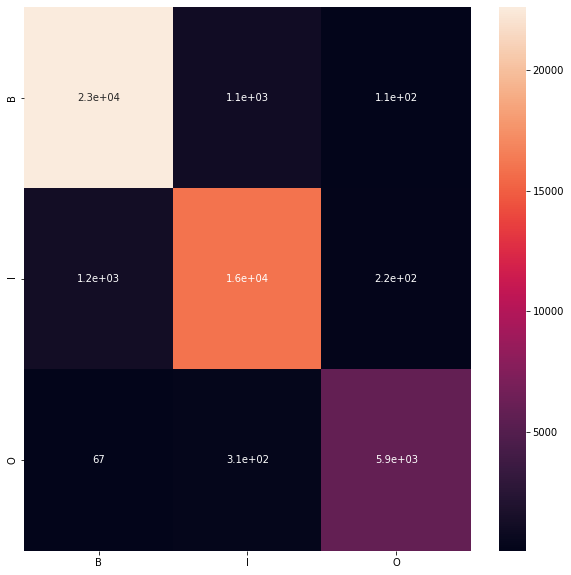

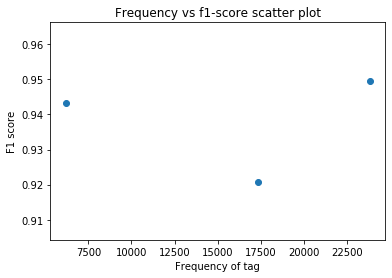

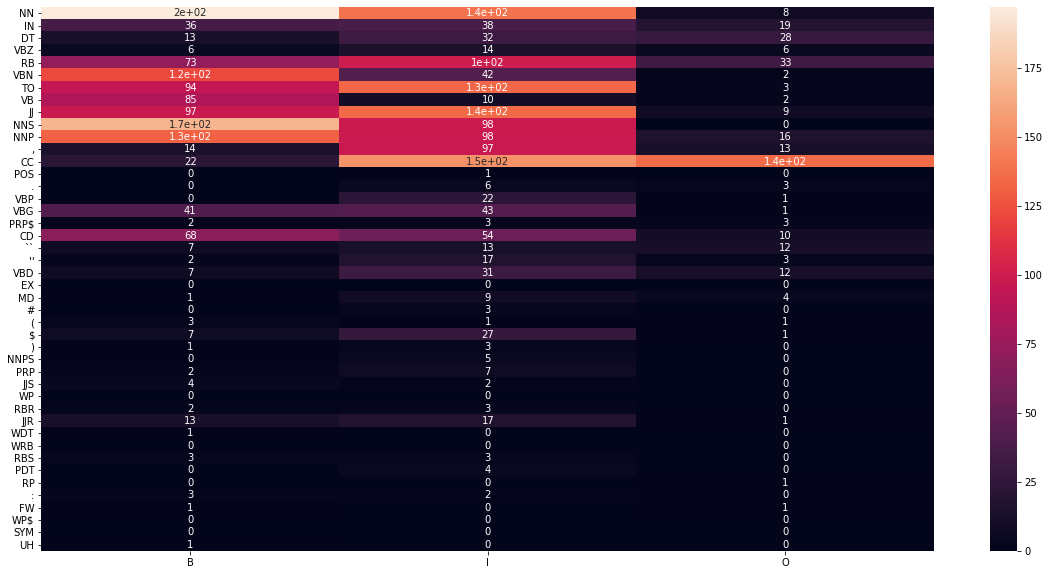

In [111]:
analyze_evaluation_object(memm_nltk_test_results, len(test_sent), mode='test')

The overall accuracy of the memm nltk model is: 96.5531084840384
The sentence accuracy of the memm nltk model is: 53.62578334825425


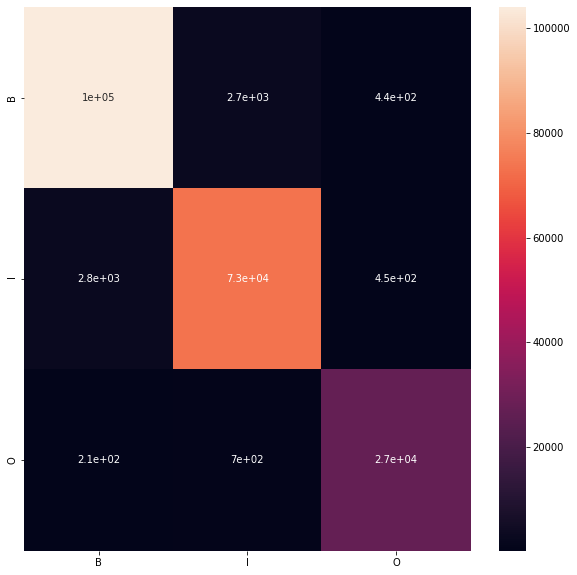

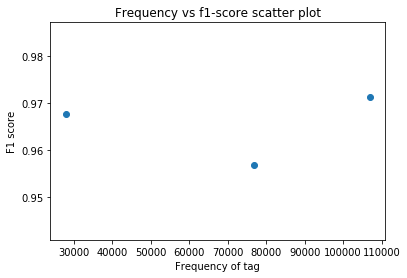

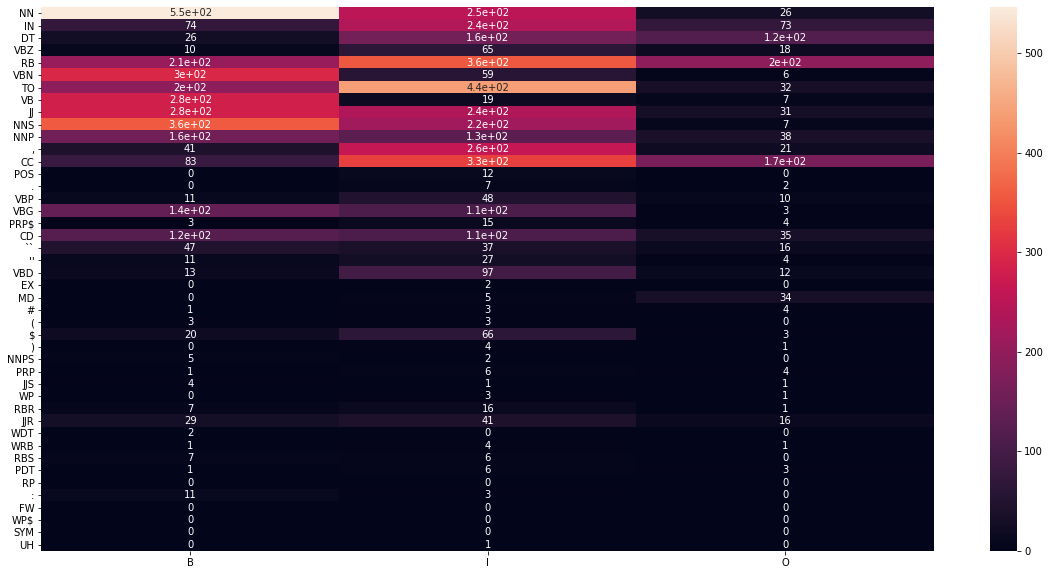

In [112]:
analyze_evaluation_object(memm_nltk_train_results, len(train_sent), mode='train')

In [77]:
# analysis on mis classified training examples
mis_predicted_sent_id_tags_train = memm_nltk_train_results['mis_predicted_sent_id_tags']

In [78]:
# random sampling some of the examples and analyzing the outcome
sampled_args = np.random.choice(len(mis_predicted_sent_id_tags_train), 100, replace=False)

# expected outcome vs actual outcome
with open('memm_nltk_mis_classified_sent.txt', 'a') as write_file:
    for index in sampled_args:
        write_file.write('Current sentence: ' + str(mis_predicted_sent_id_tags_train[index][0]) + ' ' + ' '.join(train_sent[mis_predicted_sent_id_tags_train[index][0]]) + '\n')
        write_file.write('----------------------------------------\n')
        write_file.write('Token -x- Predicted Chunk Tag -x- Actual Chunk Tag -x- Actual POS tag\n')
        write_file.write('----------------------------------------\n')

        for token_id in range(len(train_sent[mis_predicted_sent_id_tags_train[index][0]])):
            write_file.write(train_sent[mis_predicted_sent_id_tags_train[index][0]][token_id] + ' ' + mis_predicted_sent_id_tags_train[index][1][token_id] + ' ' + mis_predicted_sent_id_tags_train[index][2][token_id] + ' ' + train_pos_tags[mis_predicted_sent_id_tags_train[index][0]][token_id] + '\n')
        write_file.write('----------------------------------------\n')

In [34]:
train_feature_list_adv = produce_feature_list(train_sent, train_pos_tags, train_chunking_tags, mode='adv')

8936it [01:02, 142.19it/s]


In [57]:
maxent_classifier_adv = MaxentClassifier.train(train_feature_list_adv, max_iter=30)

  ==> Training (30 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.132
             2          -0.49508        0.892
             3          -0.33021        0.945
             4          -0.24927        0.959
             5          -0.20227        0.965
             6          -0.17183        0.968
             7          -0.15058        0.970
             8          -0.13490        0.972
             9          -0.12284        0.974
            10          -0.11325        0.976
            11          -0.10541        0.977
            12          -0.09888        0.978
            13          -0.09332        0.979
            14          -0.08853        0.980
            15          -0.08434        0.981
            16          -0.08064        0.982
            17          -0.07733        0.983
            18          -0.07436        0.984
            19          -0.07167        0.984
  

In [58]:
with open('MEMM_NLTK_ADV.pickle', 'wb') as pickle_file:
    pickle.dump(maxent_classifier_adv , pickle_file)

In [59]:
with open('MEMM_NLTK_ADV.pickle', 'rb') as pickle_file:
    maxent_classifier_adv = pickle.load(pickle_file)

In [60]:
print(assign_pos(maxent_classifier_adv, test_sent[500], test_pos_tags[500], mode='adv'))

['B', 'B', 'B', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O']


In [61]:
print(test_chunking_tags[500])

['B', 'B', 'I', 'B', 'I', 'I', 'B', 'B', 'I', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'B', 'B', 'I', 'I', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'O', 'B', 'I', 'B', 'I', 'O']


In [62]:
confusion_matrix_test, chunking_tag_rel_freq_test, pos_tag_mispredictions_test, mis_predicted_sent_id_tags_test = evaluate(maxent_classifier_adv, test_sent, test_pos_tags, test_chunking_tags, mode='adv')

100%|██████████| 2012/2012 [01:47<00:00, 18.65it/s]


In [63]:
confusion_matrix_train, chunking_tag_rel_freq_train, pos_tag_mispredictions_train, mis_predicted_sent_id_tags_train = evaluate(maxent_classifier_adv, train_sent, train_pos_tags, train_chunking_tags, mode='adv')

100%|██████████| 8936/8936 [08:08<00:00, 18.31it/s]


In [64]:
# saving the results for testing domain
with open('MEMM_NTLK_ADV_test_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_test,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_test,
        'pos_tag_mispredictions': pos_tag_mispredictions_test,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_test
    }, pickle_file)

In [65]:
# saving the results for training domain
with open('MEMM_NTLK_ADV_train_results.pickle', 'wb') as pickle_file:
    pickle.dump({
        'confusion_matrix': confusion_matrix_train,
        'chunking_tag_rel_freq': chunking_tag_rel_freq_train,
        'pos_tag_mispredictions': pos_tag_mispredictions_train,
        'mis_predicted_sent_id_tags': mis_predicted_sent_id_tags_train
    }, pickle_file)

In [113]:
with open('MEMM_NTLK_ADV_test_results.pickle', 'rb') as pickle_file:
    memm_nltk_test_results = pickle.load(pickle_file)

In [114]:
with open('MEMM_NTLK_ADV_train_results.pickle', 'rb') as pickle_file:
    memm_nltk_train_results = pickle.load(pickle_file)

The overall accuracy of the memm nltk model is: 96.1880237245921
The sentence accuracy of the memm nltk model is: 52.83300198807157


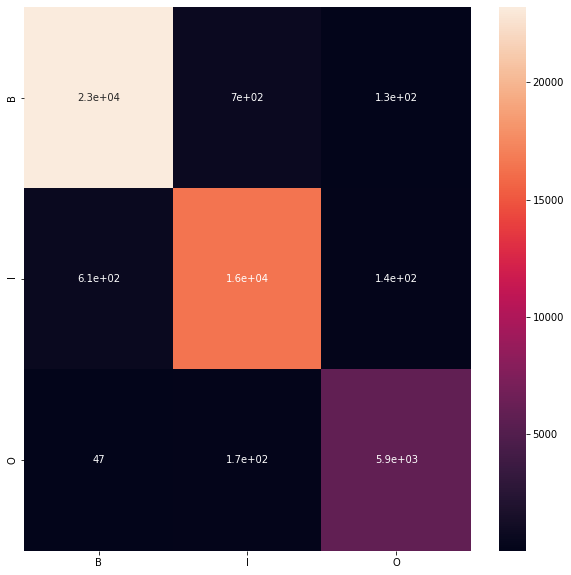

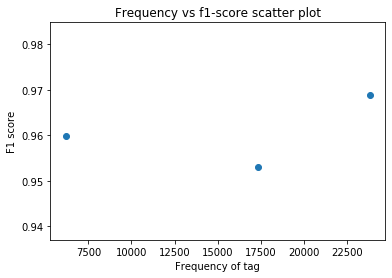

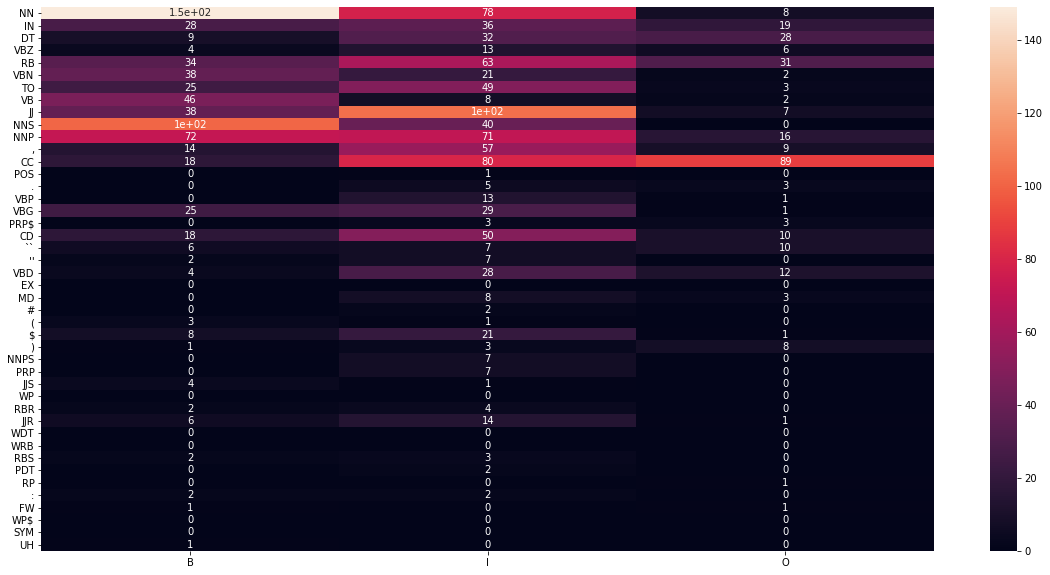

In [115]:
analyze_evaluation_object(memm_nltk_test_results, len(test_sent), mode='adv_test')

The overall accuracy of the memm nltk model is: 99.03271665871618
The sentence accuracy of the memm nltk model is: 83.33706356311549


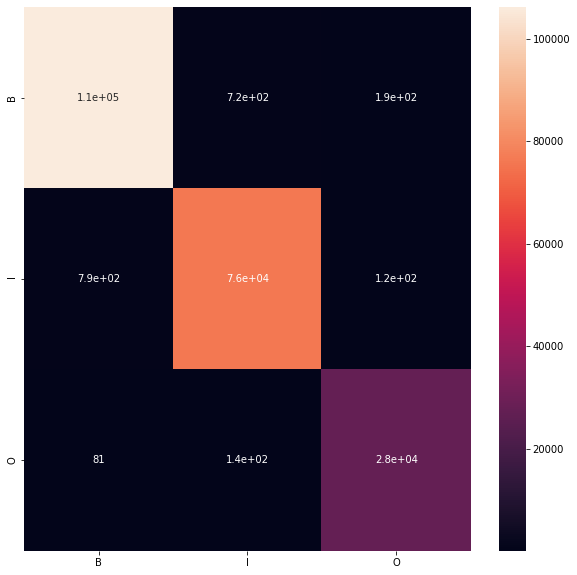

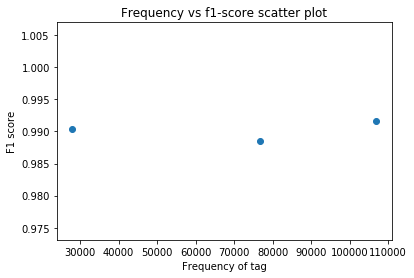

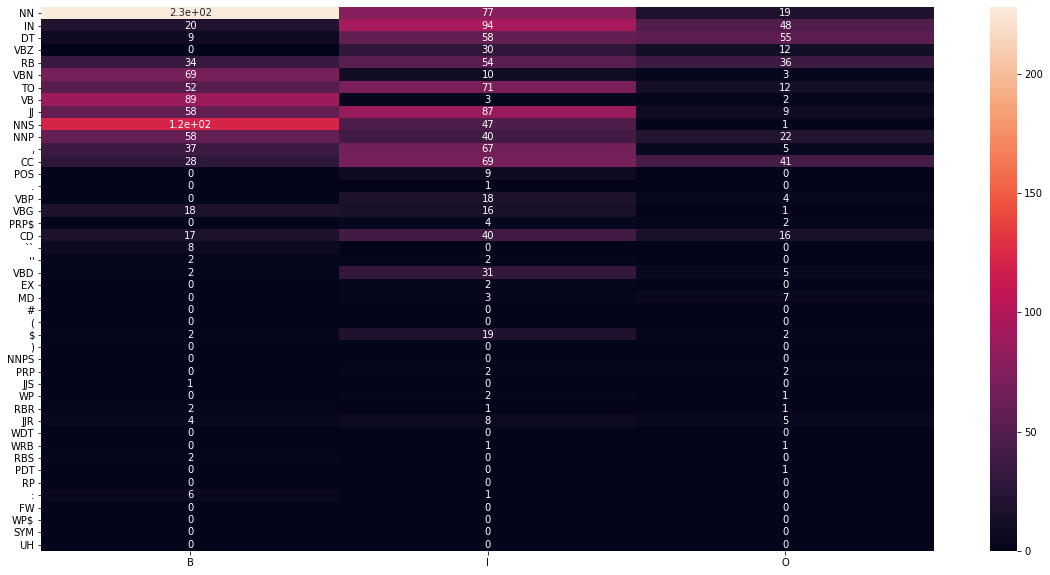

In [116]:
analyze_evaluation_object(memm_nltk_train_results, len(train_sent), mode='adv_train')

In [101]:
mis_predicted_sent_id_tags = memm_nltk_train_results['mis_predicted_sent_id_tags']

In [82]:
# random sampling some of the examples and analyzing the outcome
sampled_args = np.random.choice(len(mis_predicted_sent_id_tags_train), 100, replace=False)

# expected outcome vs actual outcome
with open('memm_nltk_mis_classified_sent_adv.txt', 'a') as write_file:
    for index in sampled_args:
        write_file.write('Current sentence: ' + str(mis_predicted_sent_id_tags_train[index][0]) + ' ' + ' '.join(train_sent[mis_predicted_sent_id_tags_train[index][0]]) + '\n')
        write_file.write('----------------------------------------\n')
        write_file.write('Token -x- Predicted Chunk Tag -x- Actual Chunk Tag -x- Actual POS tag\n')
        write_file.write('----------------------------------------\n')

        for token_id in range(len(train_sent[mis_predicted_sent_id_tags_train[index][0]])):
            write_file.write(train_sent[mis_predicted_sent_id_tags_train[index][0]][token_id] + ' ' + mis_predicted_sent_id_tags_train[index][1][token_id] + ' ' + mis_predicted_sent_id_tags_train[index][2][token_id] + ' ' + train_pos_tags[mis_predicted_sent_id_tags_train[index][0]][token_id] + '\n')
        write_file.write('----------------------------------------\n')

In [85]:
sent_id = 2059
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

Although B B IN
overall B B JJ
revenues I I NNS
were B B VBD
stronger B B JJR
, O O ,
Mr. B B NNP
Schulman I I NNP
said B B VBD
, O O ,
DEC B B NNP
`` O O ``
drew B B VBD
down B B RB
its B B PRP$
European I I JJ
backlog I I NN
'' O O ''
and O O CC
had B B VBD
flat B B JJ
world-wide I I JJ
orders I I NNS
overall B B JJ
. O O .


In [99]:
sent_id = 264
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

Jeffrey B B NNP
E. I I NNP
Levin I I NNP
was B B VBD
named I I VBN
vice B B NN
president I I NN
and O O CC
chief B B JJ
economist I I NN
of B B IN
this B B DT
commodity I I NN
futures I I NNS
and I I CC
options I I NNS
exchange I I VBP
. O O .


In [104]:
sent_id = 6319
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

The B B DT
1988 I I CD
period I I NN
was B B VBD
restated I I VBN
from B B IN
net B B JJ
income I I NN
of B B IN
$ B B $
8 I I CD
million I I CD
to B B TO
correct I I VB
an B B DT
overstatement I I NN
in B B IN
the B B DT
company I I NN
's B B POS
Boston I I NNP
Co. I I NNP
subsidiary I I NN
. O O .


In [105]:
sent_id = 8810
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

None B B NN
of B B IN
the B B DT
firms I I NNS
reported B B VBD
any B B DT
major I I JJ
damage I I NN
to B B TO
facilities B B NNS
as B B IN
a B B DT
result I I NN
of B B IN
the B B DT
quake I I NN
. O O .


In [106]:
sent_id = 3309
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

The B B DT
new I I JJ
deal I I NN
was B B VBD
considered I I VBN
the B B DT
most I I RBS
generous I I JJ
of B B IN
its B B PRP$
kind I I NN
, O O ,
both O O DT
financially B B RB
and O O CC
in B B IN
terms B B NNS
of B B IN
creative B B JJ
freedom I I NN
. O O .


In [107]:
sent_id = 1413
predicted_tag = assign_pos(maxent_classifier_adv, train_sent[sent_id], train_pos_tags[sent_id], mode='adv')
for token_id in range(len(train_sent[sent_id])):
    print(train_sent[sent_id][token_id], predicted_tag[token_id], train_chunking_tags[sent_id][token_id], train_pos_tags[sent_id][token_id])

Not B B RB
so I I RB
Michigan B B NNP
. O O .
